# London Crime Conv1D Classifier
Predicting **Crime type** using TensorFlow/Keras Conv1D Neural Network


In [1]:
# Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adamax
from tensorflow import keras
import seaborn as sns
print(sns.__version__)

2025-12-04 21:47:11.737302: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-04 21:47:11.737789: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 21:47:11.800610: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 21:47:13.360433: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

0.13.2


## Load Dataset

In [2]:
df = pd.read_csv('2022_2025_city_of_london_street.csv')
df.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,source_file,source_folder
0,5a10b2cf8fa37fbf3933f66319f1c2ce76ef9697e19442...,2024-12,City of London Police,City of London Police,-0.105965,51.518514,On or near Further/Higher Educational Building,E01000916,Camden 027B,Robbery,Investigation complete; no suspect identified,NaN,2024-12-city-of-london-street.csv,datasets
1,71ac2a8e6b747e5044b1bb5e8b93b8b13a09bf39649390...,2024-12,City of London Police,City of London Police,-0.111596,51.518281,On or near Chancery Lane,E01000914,Camden 028B,Other theft,Investigation complete; no suspect identified,NaN,2024-12-city-of-london-street.csv,datasets
2,e5dc3c4e04ebc5285c57dabef730c271df889665252ed9...,2024-12,City of London Police,City of London Police,-0.112096,51.515942,On or near Nightclub,E01000914,Camden 028B,Robbery,Status update unavailable,NaN,2024-12-city-of-london-street.csv,datasets
3,2072389e40234ffec9830716e10ba0aa4ad91fbe282bf5...,2024-12,City of London Police,City of London Police,-0.112537,51.519582,On or near Gray'S Inn Square,E01000914,Camden 028B,Shoplifting,Status update unavailable,NaN,2024-12-city-of-london-street.csv,datasets
4,5fe3737ddf7156d6fb68bb3a2b54dcb1f7bc354f5f70e9...,2024-12,City of London Police,City of London Police,-0.111596,51.518281,On or near Chancery Lane,E01000914,Camden 028B,Theft from the person,Investigation complete; no suspect identified,NaN,2024-12-city-of-london-street.csv,datasets


## Data Preprocessing

In [3]:
# Drop duplicates rows
df.drop_duplicates(inplace=True)

# Drop the Crime ID, source column, and source file columns since they contain duplicate information/administrative purposes when merging the datasets, or are identifiers.
df.drop(columns=['Crime ID', 'Context', 'source_file', 'source_folder'], inplace=True)

In [4]:
# Strip column names
# REASON: In some cases, when reading CSV files, extra spaces can be inadvertently added in the column names.
# This can lead to issues when trying to access these columns later in the code, as the names won't match exactly.
df.columns = df.columns.str.strip()

In [5]:

# Fill missing numeric values using KNN imputation, which in this case is the GPS coordinates (Longitude, Latitude)
numeric_cols = ['Longitude', 'Latitude']
imputer = KNNImputer(n_neighbors=5)
# Note: For production, fit the imputer on the training set only to avoid data leakage.
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Encode target values, so that the crime ('Crime type') can be used for classification, (LABELS) to (NUMERICAL RANGE)
target_col = 'Crime type'
encoder = LabelEncoder()

df['target_encoded'] = encoder.fit_transform(df[target_col])
num_classes = df['target_encoded'].nunique()

In [6]:
# Features: numeric and categorical
categorical_cols = ['Reported by', 'Falls within', 'LSOA code', 'LSOA name']
df_encoded = pd.get_dummies(df[categorical_cols])

X = pd.concat([df[numeric_cols], df_encoded], axis=1).values
y = to_categorical(df['target_encoded'], num_classes=num_classes)

In [7]:
# Standardize numeric features
scaler = StandardScaler()
X[:, :len(numeric_cols)] = scaler.fit_transform(X[:, :len(numeric_cols)])

X = X.astype("float32")  # ensure proper dtype

## Train/Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Model Definition

In [ ]:
 
model = Sequential()
model.add(Input(X[1].shape))
model.add(Dense(64, activation='relu'))
model.add(Dense(10))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train,y_train,verbose=0,epochs=128)
model.summary()
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

#path to where the file will be saved
save_path = "Model"

# save neural network structure to JSON (no weights)
model_json = model.to_json()
with open(os.path.join(save_path,"network.json"), "w") as json_file:
    json_file.write(model_json)

# save entire network to HDF5 (save everything, suggested)
model.save(os.path.join(save_path,"network.h5"))

2025-12-04 21:47:16.905115: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


KeyboardInterrupt: 

## Training

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=512
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1623 - val_loss: 2.1842
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1623 - val_loss: 2.1842
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1598 - val_loss: 2.1835
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1598 - val_loss: 2.1835
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1592 - val_loss: 2.1830
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1592 - val_loss: 2.1830
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1589 - val_loss: 2.1831
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1589 - val_loss: 2.1831
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1586 - val_loss: 2.1831
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1586 - val_loss: 2.1831
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1583 - val_loss: 2.1832
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1583 - val_loss:

In [ ]:
#make predictions (will give a probability distribution)
pred_hot = model.predict(X_test)
#now pick the most likely outcome
pred = np.argmax(pred_hot,axis=1)
y_compare = np.argmax(y_test,axis=1) 
#calculate accuracy
score = metrics.accuracy_score(y_compare, pred)

print("Accuracy score: {}".format(score))

print(pred_hot[:5])
print(pred)

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy score: 0.26874754613270513
[[3.44301350e-02 1.60954129e-02 4.15696315e-02 3.74849848e-02
  4.42480557e-02 7.96825532e-03 3.42056870e-01 7.74119375e-03
  5.83627857e-02 1.69753358e-02 9.98158306e-02 1.04373738e-01
  1.76347122e-02 1.71243101e-01]
 [1.03441682e-11 6.24101339e-25 9.07373530e-24 1.65327169e-10
  8.57826591e-01 1.91340458e-17 9.33272386e-05 4.99689290e-10
  5.35335675e-16 8.69794925e-15 0.00000000e+00 1.05427533e-08
  5.33097517e-03 1.36749104e-01]
 [1.64939817e-02 1.76179055e-02 1.93036962e-02 2.50232127e-02
  8.81514624e-02 8.39707777e-02 1.60070524e-01 1.27794212e-02
  5.97148091e-02 1.44741805e-02 1.23905644e-01 1.57307312e-01
  9.76548158e-03 2.11421654e-01]
 [3.44412997e-02 1.45527376e-02 3.86522636e-02 3.71169299e-02
  4.22496535e-02 6.79893373e-03 3.50272119e-01 7.59338913e-03
  6.60129786e-02 1.68934148e-02 1.01338856e-01 7.39064962e-02
  1.80421844e-02 1.92128703e-01]
 [

## Evaluation

In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
                              precision    recall  f1-score   support

       Anti-social behaviour       0.00      0.00      0.00       162
               Bicycle theft       0.00      0.00      0.00       120
                    Burglary       0.00      0.00      0.00       190
   Criminal damage and arson       0.00      0.00      0.00       190
                       Drugs       0.21      0.01      0.02       299
                 Other crime       0.33      0.01      0.02       106
                 Other theft       0.28      0.58      0.38      1119
       Possession of weapons       0.00      0.00      0.00        44
                Public order       0.00      0.00      0.00       345
                     Robbery       0.00      0.00      0.00        95
                 Shoplifting       0.28      0.36      0.31       685
       Theft from the person       0.26      0.20      0.23       777
   

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


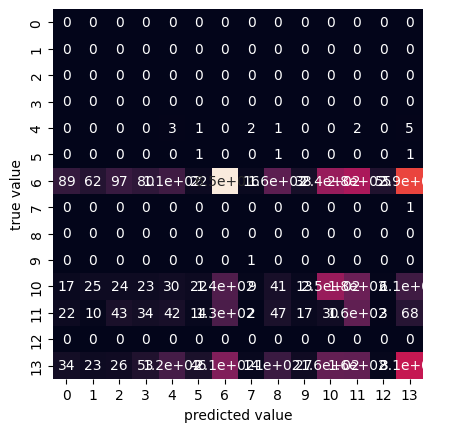

In [ ]:
mat = confusion_matrix(pred, y_compare)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

## Plot Training Curves

KeyError: 'accuracy'

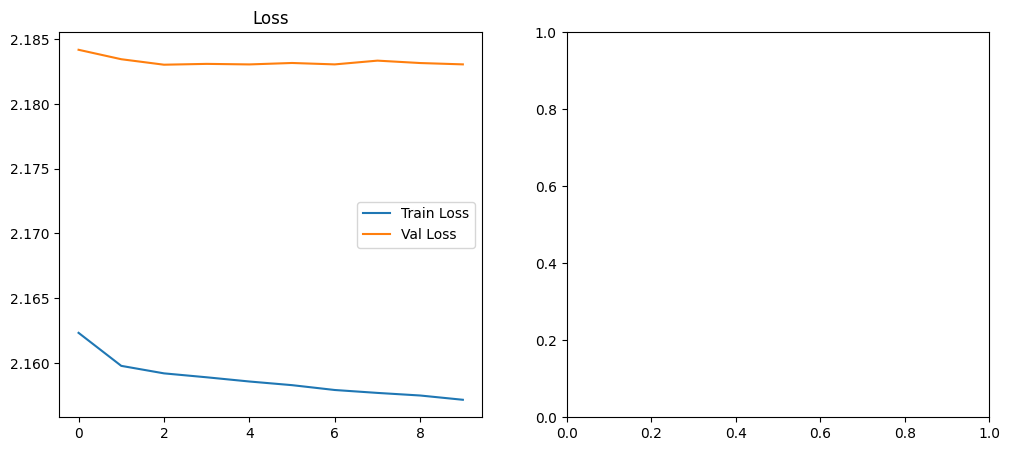

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.show()